## Square lattice Fermi surface away from half-filling

In [10]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np

In [11]:
np.random.seed(10)

N = 30  # sample points
mu = -2  # chemical potential
n_iter = 1000  # number of iterations

x_plot = np.arange(0, np.pi, 0.01)
y_plot = np.arccos(-mu/2-np.cos(x_plot))
[XX, YY] = np.meshgrid(x_plot, x_plot)


C:\Users\12568\AppData\Local\Temp\ipykernel_8360\343741655.py:8: RuntimeWarning: invalid value encountered in arccos
  y_plot = np.arccos(-mu/2-np.cos(x_plot))


In [12]:
def samples(N):
    # Generate random kx and ky
    kx = np.pi*np.array([np.random.random() for i in range(N)]).reshape((N, 1))
    ky = np.pi*np.array([np.random.random() for i in range(N)]).reshape((N, 1))

    # Calculate the fermi energy
    E = -2*(np.cos(kx)+np.cos(ky))
    occupancy = np.array([E[i] <= mu for i in range(N)]).reshape((N, 1))

    return kx, ky, occupancy


def initialize(kx, ky, symmetric=False):
    # Generate X
    if symmetric:
        X = np.concatenate((kx+ky, kx**2+ky**2, kx*ky), axis=1)
    else:
        X = np.concatenate((kx, ky, kx**2, ky**2, kx*ky), axis=1)
    X = np.c_[np.ones((len(X), 1)), X]

    # Initialize theta
    theta = np.zeros((X.shape[1], 1))

    return X, theta


In [13]:
# Logistic regression
class LR:
    def __init__(self, kx, ky, occupancy):
        # Generate X
        X = np.concatenate((kx, ky, kx**2, ky**2, kx*ky), axis=1)
        self.X = np.c_[np.ones((len(X), 1)), X]

        # Initialize theta
        self.theta = np.zeros((self.X.shape[1], 1))

        # Construct y
        self.y = np.where(occupancy, 1., 0.).reshape((len(occupancy), 1))

    # Computes the sigmoid function
    @staticmethod
    def sigmoid(theta, x):
        return 1 / (1 + np.exp(-np.dot(x, theta)))

    # Computes the gradient of the cost function at the point theta
    def gradient(self):
        m = self.X.shape[0]
        return (1 / m) * np.dot(self.X.T, self.sigmoid(self.theta, self.X) - self.y)

    # Performs gradient descent to learn theta
    def fit(self, n_iter=1000):
        alpha = 0.5
        I = int(n_iter/3)
        for i in range(n_iter):
            # Reduce the learning rate by half every n_iter/3 iterations
            if i % I == 0:
                alpha /= 2
            self.theta = self.theta-alpha*self.gradient()
        self.w_ = self.theta[:, 0]
        return self


In [14]:
# SVM Method
class SVM:
    def __init__(self, kx, ky, occupancy, symmetric=False):
        # Generate X
        if symmetric:
            self.X, self.theta = initialize(kx, ky, symmetric=True)
        else:
            self.X, self.theta = initialize(kx, ky)

        # Construct y
        self.y = np.where(occupancy, 1., -1.).reshape((len(occupancy), 1))

    @staticmethod
    def hinge(X, y, theta):
        pred = 1 - np.multiply(y, (X.dot(theta)))
        loss = np.maximum(np.zeros(pred.shape), pred)
        hinge = np.sum(loss)
        return hinge

    @staticmethod
    def cost(theta, y, h):
        m = float(len(y))
        theta2 = np.square(theta[1:])
        cost = (1/(2*m)) * np.sum(theta2) + (1/m) * h
        return cost

    def check(self):
        # Returns a matrix of 1s and 0s
        fx = np.multiply(self.y, (self.X.dot(self.theta)))
        check = np.less(fx, np.ones(fx.shape))
        check = np.where(check == True, 1, 0)
        return check

    def fit(self, n_iter=1000):
        '''
        n_iter = number of iterations
        Returns cost history, hinge history, and theta history
        '''
        m = float(self.y.shape[0])

        cost_history = np.zeros(n_iter)
        hinge_history = np.zeros(n_iter)
        theta_history = []

        alpha = 0.1
        for i in range(n_iter):
            I = int(n_iter/3)
            # Reduce the learning rate by half every iterations/3 iterations
            if i % I == 0:
                alpha /= 2
            self.theta = self.theta + alpha * \
                ((np.multiply(self.check(), self.y)).T.dot(self.X)).T
            self.theta[1:] = self.theta[1:] - alpha*self.theta[1:]/m
            theta_history.append(self.theta)
            h = self.hinge(self.X, self.y, self.theta)
            hinge_history[i] = h
            cost_history[i] = self.cost(self.theta, self.y, h)

        return cost_history, hinge_history, theta_history

    @staticmethod
    def accuracy(X, y, theta):
        fx = np.multiply(y, (X.dot(theta)))
        check = np.less(fx, np.zeros(fx.shape))
        check = np.where(check == True, 0, 1)
        return np.sum(check)/X.shape[0]


In [15]:
def train():
    W0 = []    # Weights for logistic regression
    W1 = []    # Weights for SVM (non-symmetric)
    W2 = []    # Weights for SVM (symmetric)
    J1 = []    # Cost history for SVM (non-symmetric)
    J2 = []    # Cost history for SVM (symmetric)
    H1 = []    # Hinge loss history for SVM (non-symmetric)
    H2 = []    # Hinge loss history for SVM (symmetric)
    X1_train = []
    X2_train = []
    Y_train = []

    for kx, ky, occupancy in zip(KX, KY, Occupancy):

        # Create the models
        model0 = LR(kx, ky, occupancy)
        model1 = SVM(kx, ky, occupancy)
        model2 = SVM(kx, ky, occupancy, symmetric=True)

        # Train the modelS
        model0.fit(n_iter)
        cost_history, hinge_history, theta_history = model1.fit(n_iter)
        cost_history2, hinge_history2, theta_history2 = model2.fit(n_iter)

        
        # Store the weights, cost history, hinge history, and theta history
        J1.append(cost_history)
        J2.append(cost_history2)
        H1.append(hinge_history)
        H2.append(hinge_history2)
        W0.append(model0.w_)
        W1.append(theta_history)
        W2.append(theta_history2)
        X1_train.append(model0.X)
        X2_train.append(model2.X)
        Y_train.append(model1.y)

    return W0, W1, W2, J1, J2, H1, H2, X1_train, X2_train, Y_train


In [16]:

def plot_samples(kx, ky, occupancy, ax):
    d0 = ax.scatter(kx[occupancy], ky[occupancy], label='Filled', c='r')
    d1 = ax.scatter(kx[np.invert(occupancy)],
                    ky[np.invert(occupancy)], label='Unfilled', c='b')
    c0, = ax.plot(x_plot, y_plot, label='Fermi Surface', linestyle=':')
    return d0, d1, c0


def plot_c(w, symmetric=False):
    if symmetric:
        return w[0]+w[1]*(XX+YY)+w[2] * (XX**2+YY**2)+w[3]*XX*YY
    else:
        return w[0]+w[1]*XX+w[2]*YY+w[3] * XX**2+w[4]*YY**2+w[5]*XX*YY


def plot_loss(ax, a, b, title, lim=None):
    ax.plot(a, label='Train')
    ax.plot(b, label='Test')
    ax.legend()
    ax.set_xlabel('No. of iterations')
    ax.set_yscale('log')
    ax.set_ylabel('$J(\Theta)$')
    ax.set_title(title)
    if lim != None:
        ax.set_xlim(lim)


def plot_accuracy(ax, a, b, title, lim=None):
    ax.plot(a, label='Train')
    ax.plot(b, label='Test')
    ax.legend(loc='lower right')
    ax.set_xlabel('No. of iterations')
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.825, 1.01)
    if lim != None:
        ax.set_xlim(lim)


def plot_all(j, ax, a, b, labels, cs=['g', 'magenta'], symmetric=False, first=False, title=False):
    d0, d1, c0 = plot_samples(KX[j], KY[j], Occupancy[j], ax)
    if not symmetric:
        c1 = ax.contour(XX, YY, plot_c(a[j]), [0], colors=cs[0])
    else:
        c1 = ax.contour(XX, YY, plot_c(a[j][-1]), [0], colors=cs[0])

    c2 = ax.contour(XX, YY, plot_c(
        b[j][-1], symmetric=symmetric), [0], colors=cs[1])

    h1, _ = c1.legend_elements()
    h2, _ = c2.legend_elements()
    first_legend = ax.legend([h1[0], h2[0]], labels, loc='upper right')

    # Add the legend manually to the Axes.
    ax.add_artist(first_legend)

    if first:
        ax.legend(handles=[d0, d1, c0], loc='upper left')
    if title:
        ax.set_title('Training data')

    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, np.pi)
    ax.set_xlabel('$k_x$')
    ax.set_ylabel('$k_y$')
    ax.set_xticks([0, np.pi/2, np.pi], ['0', '$\pi/2$', '$\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi], ['0', '$\pi/2$', '$\pi$'])


In [17]:
# Generate training samples
KX = []
KY = []
Occupancy = []
for i in range(9):
    kx, ky, occupancy = samples(N)
    KX.append(kx)
    KY.append(ky)
    Occupancy.append(occupancy)


In [18]:
# Train the models
W0, W1, W2, J1, J2, H1, H2, X1_train, X2_train, Y_train = train()


### 1. With chemical potential $\mu=-2$, $N_{training}=30$ and features $X_{1}=[k_{x},k_{y},k^2_{x},k^2_{y},k_{x}k_{y}]$, we have the following results:

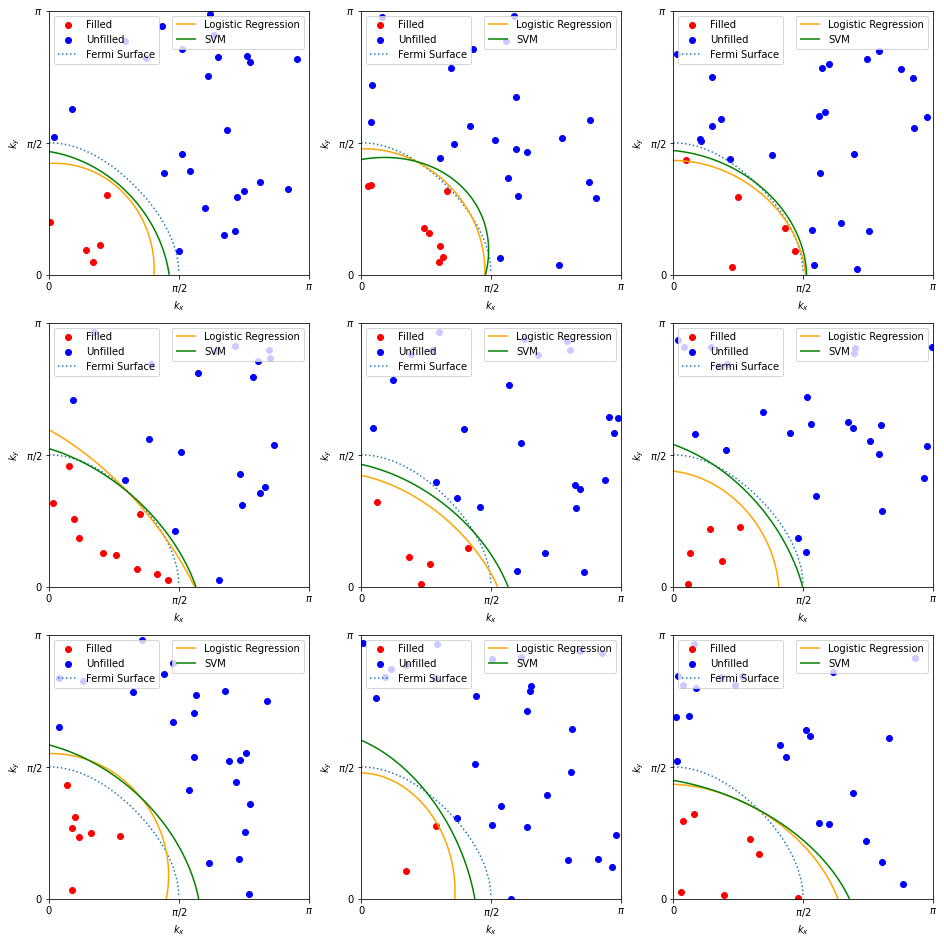

In [19]:
# Plot 3x3 figures
fig, axs = plt.subplots(3, 3, figsize=(13, 13), layout='constrained')
axs = axs.flat
for j in range(9):
    ax = axs[j]

    # Set colors
    cs = ['orange', 'g']

    labels = ['Logistic Regression', 'SVM']

    plot_all(j, ax, W0, W1, labels, cs=cs, first=j+1)

plt.show()


Based on the above figure, it is clear that both methods are significantly impacted by a lack of samples. While there may be some variation in results across different sample sets, the decision boundaries generated by the two methods are generally similar when using the same sample set. As such, we can conclude that both methods suffer to a similar extent.

### 2. With features $X_{2}=[k_{x}+k_{y},k^2_{x}+k^2_{y},k_{x}k_{y}]$, we have the following results:

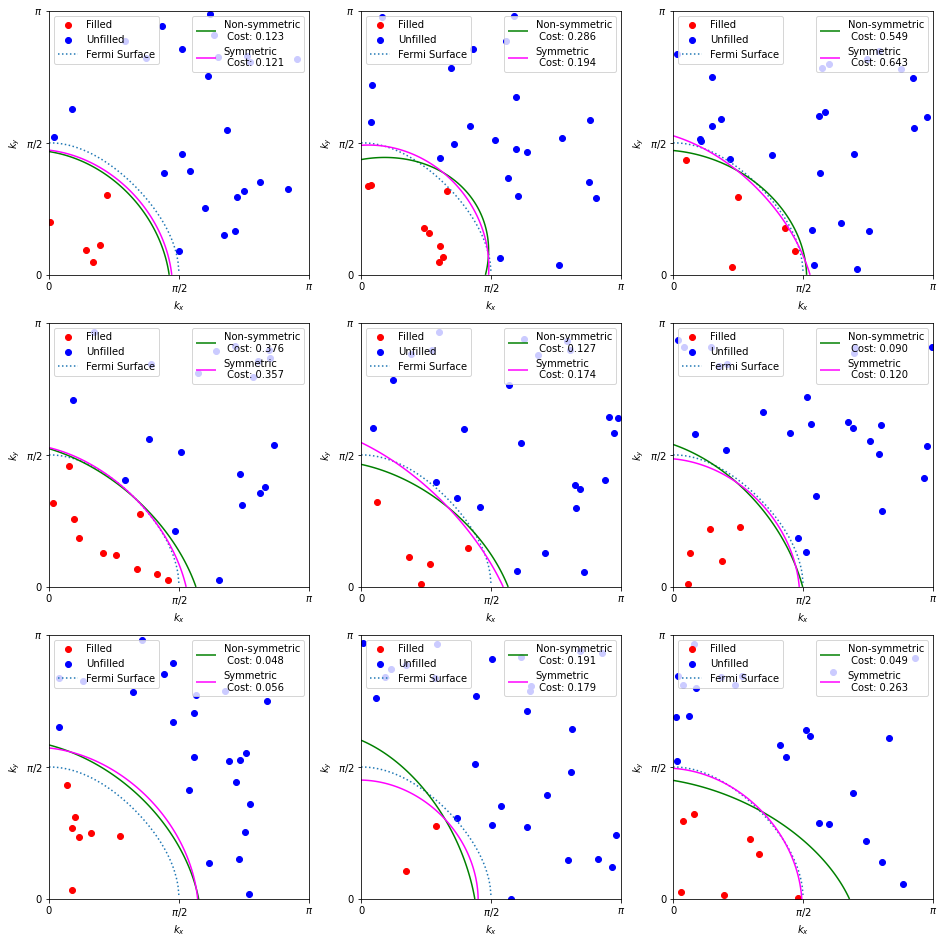

In [20]:

fig, axs = plt.subplots(3, 3, figsize=(13, 13), layout='constrained')
axs = axs.flat
for j in range(9):
    ax = axs[j]

    labels = ['Non-symmetric\n Cost: {:.3f}'.format(
        J1[j][-1]), 'Symmetric\n Cost: {:.3f}'.format(J2[j][-1])]

    plot_all(j, ax, W1, W2, labels,  symmetric=True, first=j+1)

plt.show()


While adopting symmetric features usually increases costs, it results in visually better decision boundaries as shown above, especially when the generated samples are unevenly distributed. By leveraging the symmetry of the problem, our model becomes more resilient to a lack of samples. In summary, the use of symmetric features leads to increased robustness and improved performance.

### 3. With $N_{test}=200$, we have the following results:

In [21]:
# Testing sample size
N_test = 200

# Generate testing samples
kx_t, ky_t, occupancy_t = samples(N_test)
X1_t, _ = initialize(kx_t, ky_t)
X2_t, _ = initialize(kx_t, ky_t, symmetric=True)
y_t = np.where(occupancy_t, 1., -1.).reshape((N_test, 1))


In [22]:
def test(j, lim=None):
    """ test the j-th sample set, where 0<=j<=8 """
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flat
    ax = axs[0]

    titles1 = ['Hinge Loss with Non-Symmetric Features',
               'Hinge Loss with Symmetric Features']
    titles2 = ['Accuracy with Non-Symmetric Features',
               'Accuracy with Symmetric Features']

    H = (([H1[j][i]/N for i in range(n_iter)],
          [SVM.hinge(X1_t, y_t, W1[j][i])/N_test for i in range(n_iter)]),
         ([H2[j][i]/N for i in range(n_iter)],
          [SVM.hinge(X2_t, y_t, W2[j][i])/N_test for i in range(n_iter)]))

    A = (([SVM.accuracy(X1_train[j], Y_train[j], W1[j][i])
           for i in range(n_iter)],
          [SVM.accuracy(X1_t, y_t, W1[j][i]) for i in range(n_iter)]),
         ([SVM.accuracy(X2_train[j], Y_train[j], W2[j][i])
          for i in range(n_iter)],
         [SVM.accuracy(X2_t, y_t, W2[j][i]) for i in range(n_iter)]))

    labels = ['Non-symmetric', 'Symmetric']
    plot_all(j, ax, W1, W2, labels, symmetric=True, first=True, title=True)

    for k in range(2):
        plot_loss(axs[k+1], H[k][0], H[k][1], titles1[k], lim=lim)
    for k in range(2):
        plot_accuracy(axs[k+4], A[k][0], A[k][1], titles2[k], lim=lim)

    print('{:<25}|{:>15}|{:>15}'.format(
        'Sample Set {}'.format(j+1), 'Non-Symmetric', 'Symmetric'))
    print('-'*58)
    print('{:<25}|{:>15.03f}|{:>15.03f}'.format(
        'Final Hinge Loss (train)', H[0][0][-1], H[1][0][-1]))
    print('{:<25}|{:>15.03f}|{:>15.03f}'.format(
        'Final Hinge Loss (test)', H[0][1][-1], H[1][1][-1]))
    print('{:<25}|{:>15.03f}|{:>15.03f}'.format(
        'Final Accuracy (train)', A[0][0][-1], A[1][0][-1]))
    print('{:<25}|{:>15.03f}|{:>15.03f}'.format(
        'Final Accuracy (test)', A[0][1][-1], A[1][1][-1]))

    fig.delaxes(axs[3])
    plt.show()


Sample Set 1             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.000
Final Hinge Loss (test)  |          0.047|          0.033
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.980|          0.985


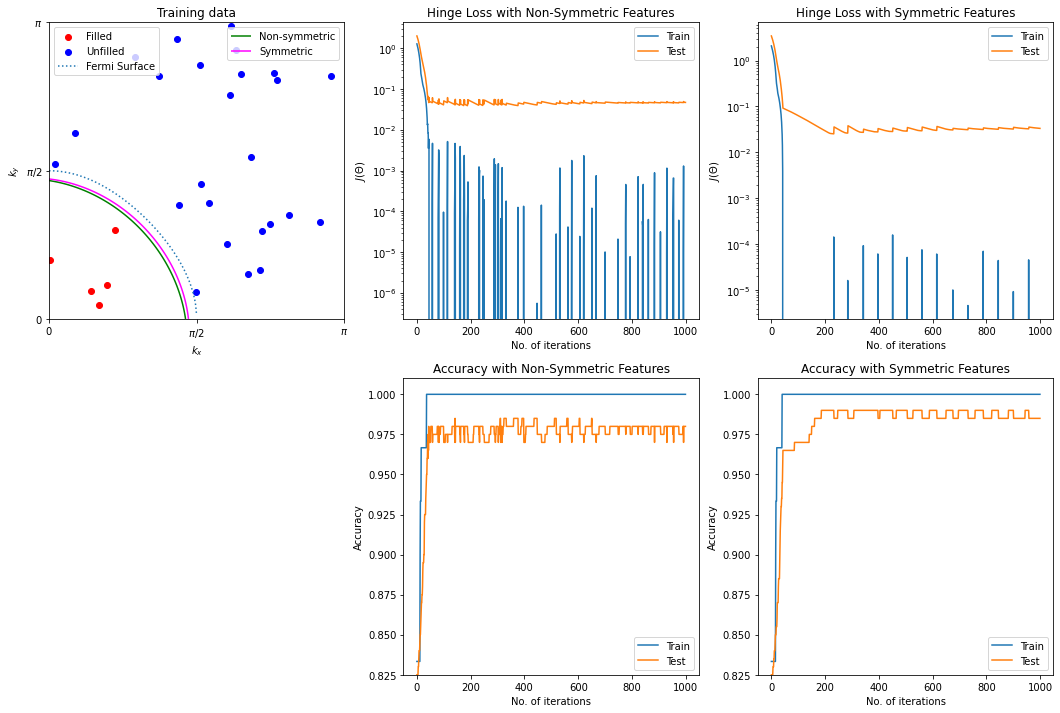

Sample Set 2             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.000
Final Hinge Loss (test)  |          0.062|          0.049
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.975|          0.975


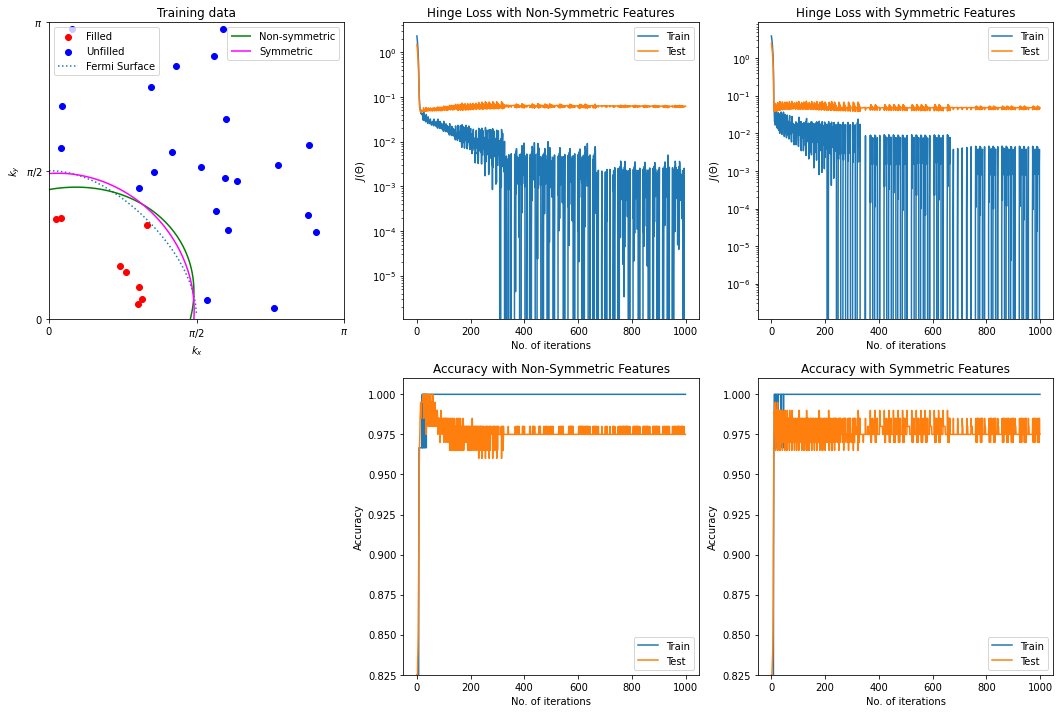

Sample Set 3             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.002|          0.018
Final Hinge Loss (test)  |          0.030|          0.012
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.980|          0.995


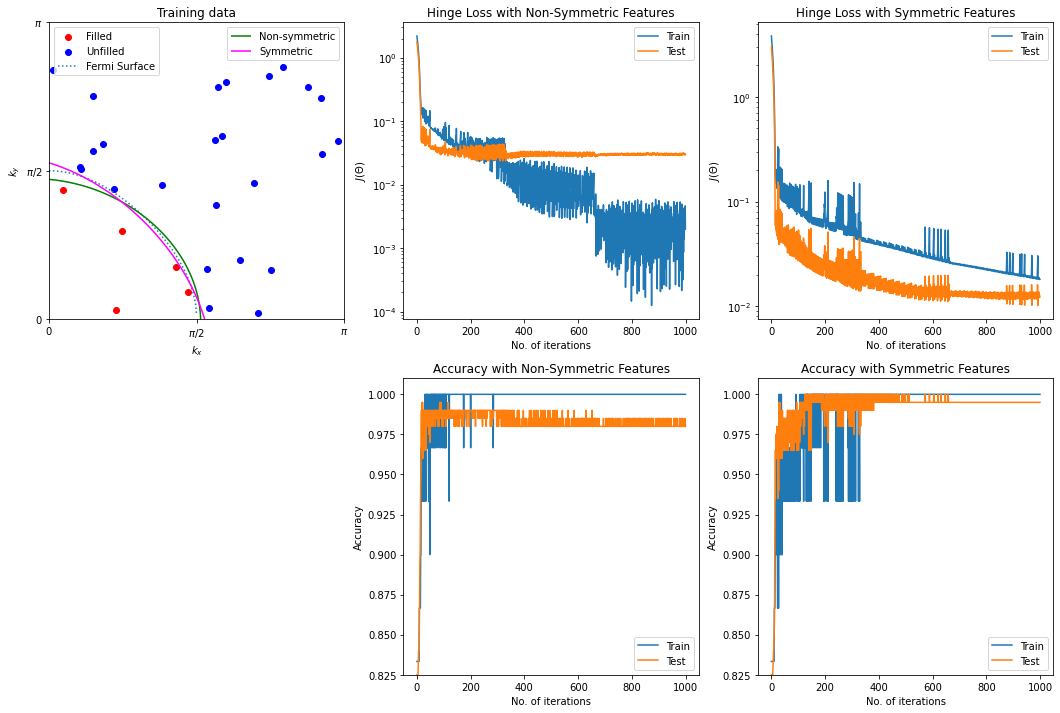

Sample Set 4             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.002
Final Hinge Loss (test)  |          0.026|          0.022
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.990|          0.995


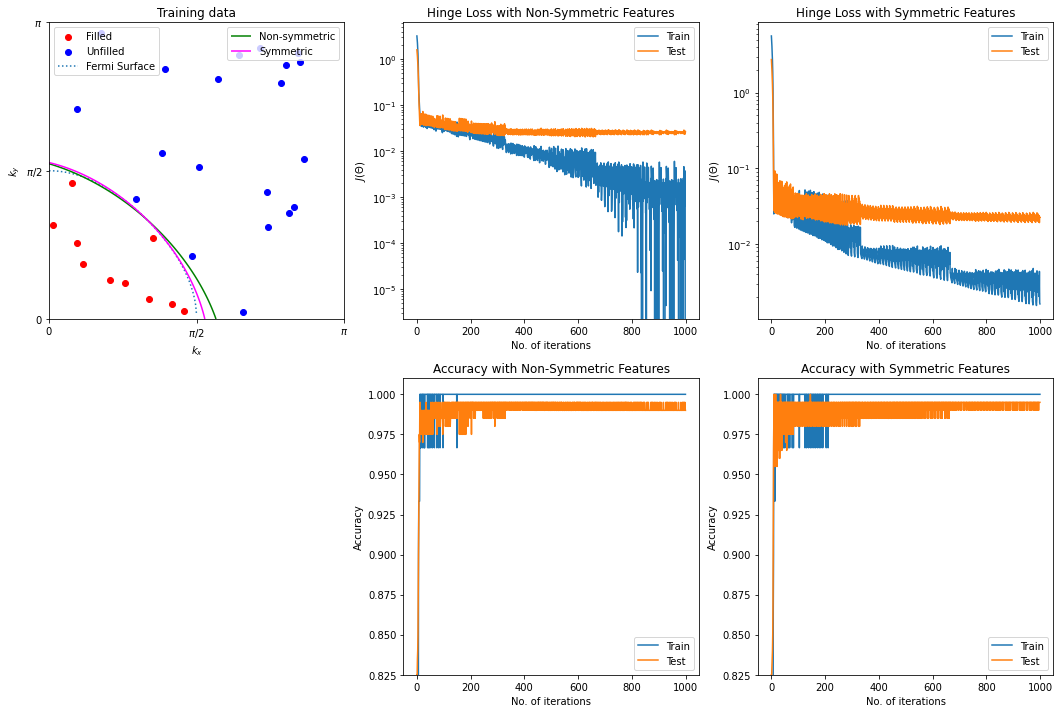

Sample Set 5             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.000
Final Hinge Loss (test)  |          0.043|          0.024
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.980|          0.995


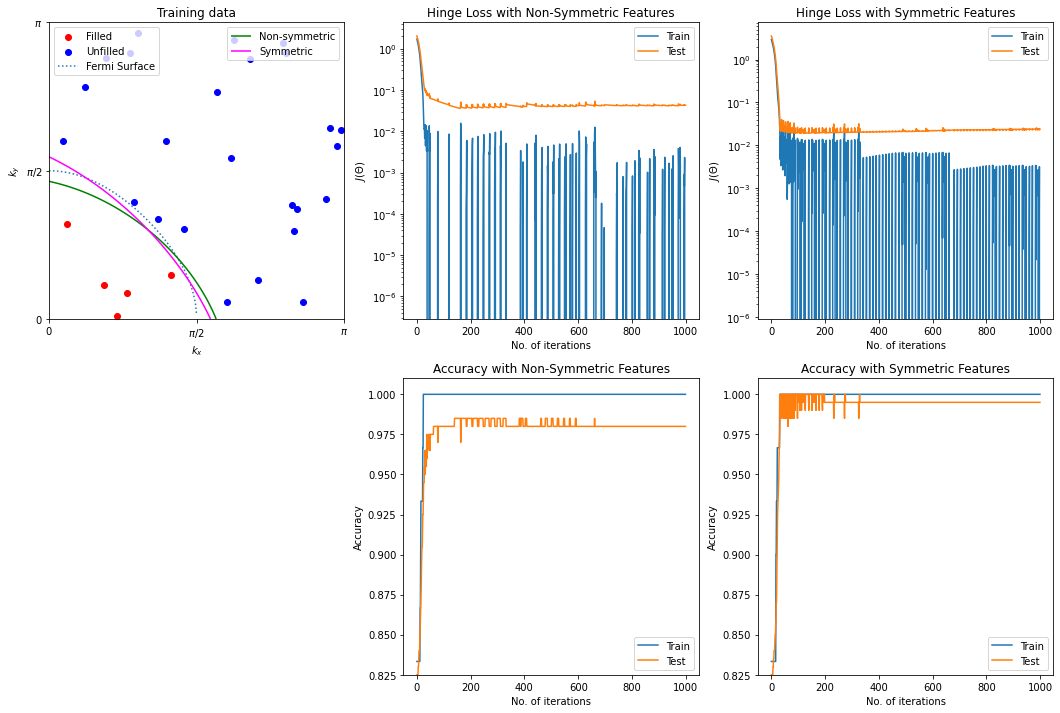

Sample Set 6             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.000
Final Hinge Loss (test)  |          0.042|          0.032
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          1.000|          1.000


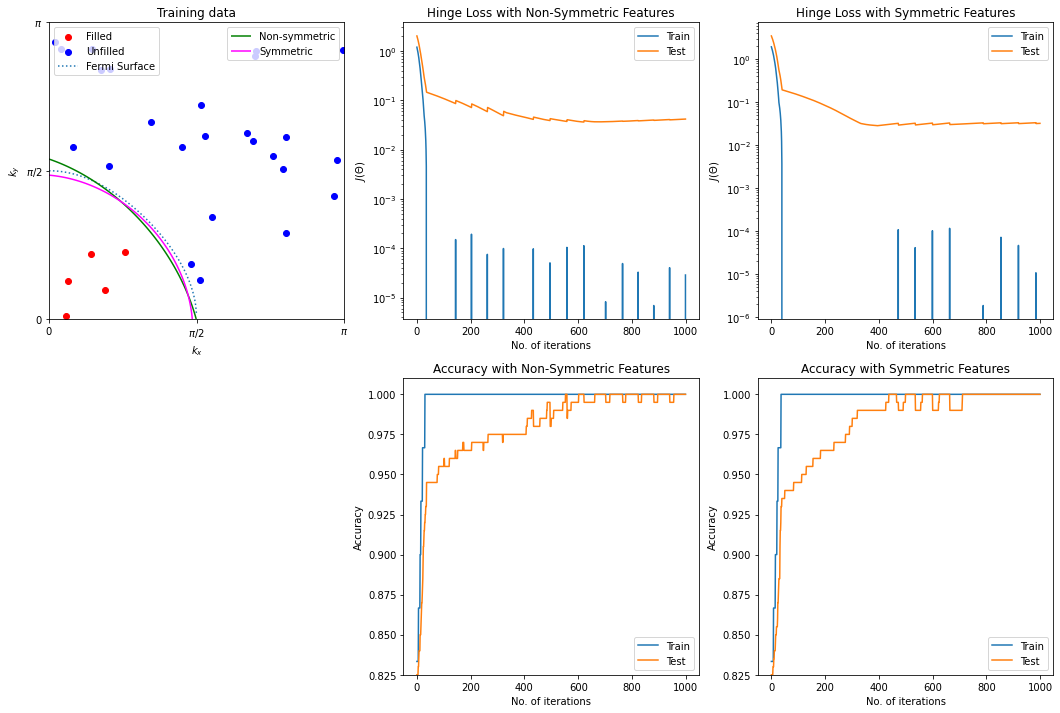

Sample Set 7             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.000
Final Hinge Loss (test)  |          0.096|          0.116
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.955|          0.945


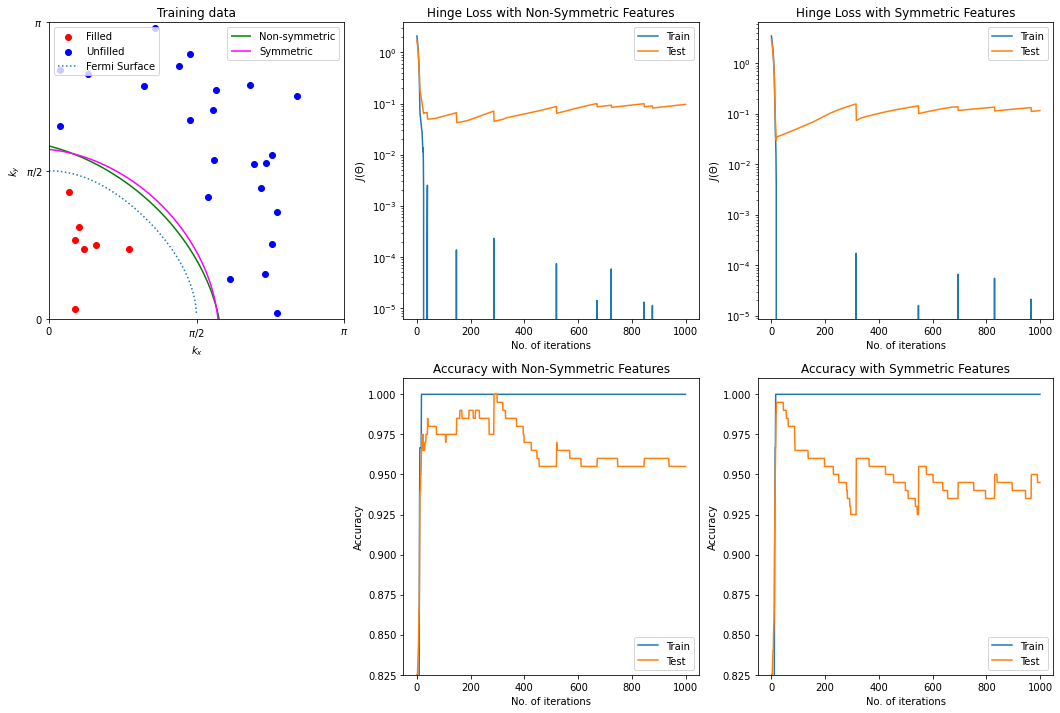

Sample Set 8             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.001|          0.001
Final Hinge Loss (test)  |          0.058|          0.043
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.970|          0.980


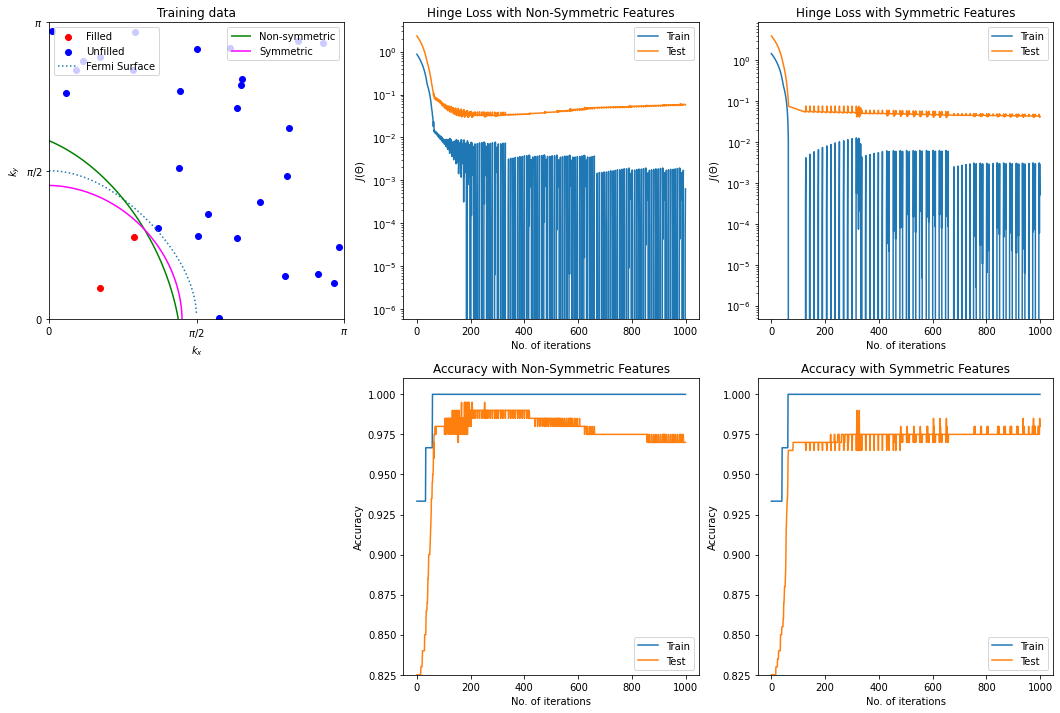

Sample Set 9             |  Non-Symmetric|      Symmetric
----------------------------------------------------------
Final Hinge Loss (train) |          0.000|          0.021
Final Hinge Loss (test)  |          0.077|          0.027
Final Accuracy (train)   |          1.000|          1.000
Final Accuracy (test)    |          0.975|          0.995


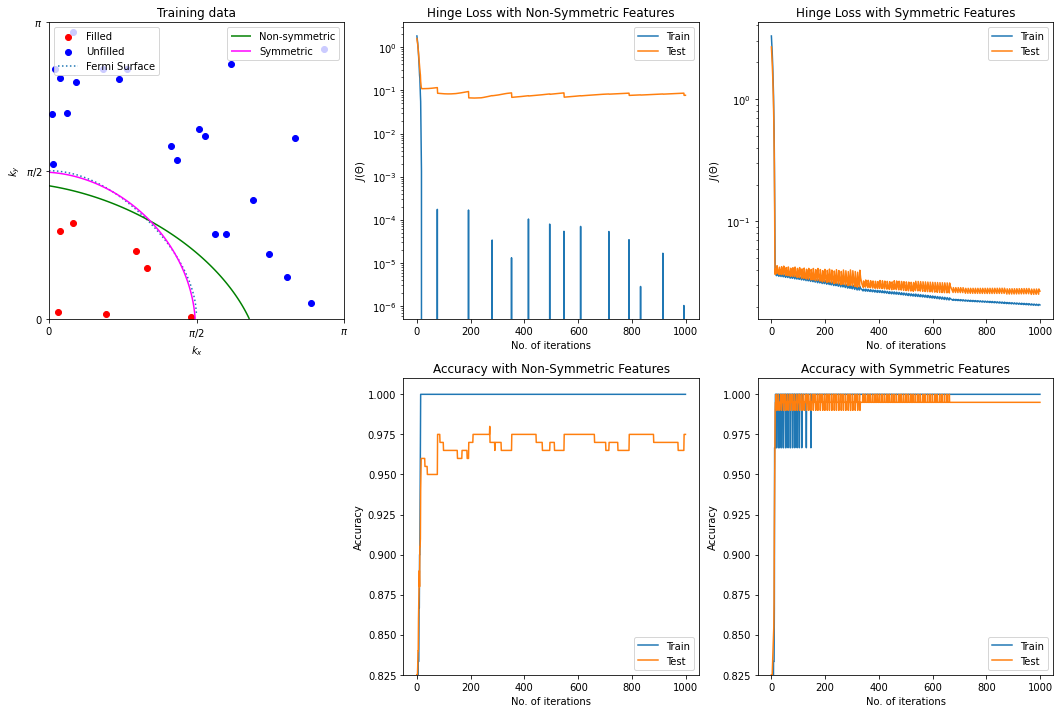

In [23]:
for j in range(9):
     test(j)


The extent to which adopting symmetric features improves performance can vary. When training samples are distributed relatively evenly, both methods may achieve high accuracy and low Hinge loss on testing samples, resulting in limited improvement. However, in cases where training samples do not represent the underlying pattern well, using symmetric features can substantially enhance the model's forecastability.

### 4. Advantages of using $X_{2}$ comparing to $X_{1}$. 

1. Firstly, incorporating $X_{2}$​ into the model can help to reduce overfitting. When using $X_{1}$​, we often observe a rapid drop in the Hinge loss during testing at the beginning, followed by a slight increase thereafter, despite the fact that the Hinge loss during training continues to decrease. This suggests that the model using $X_{1}$​ may not generalize well to new data. In contrast, this issue is largely mitigated, if not entirely avoided, when using $X_{2}$​. In some cases, we even achieve a Hinge loss during testing with $X_{2}$​ comparable to that during training, which was rarely observed with non-symmetric features.

2. Secondly, using $X_{2}$ can potentially reduce computational requirements and memory storage. This is because $X_{2}$ only involves learning four weights, while $X_{1}$ requires six, and the dimension of $X$ is equal to $N \times$ (number of features + 1). Consequently, the difference in training time can be significant, particularly when $N$ is large. Below, we present the comparison of training time for $X_{1}$ and $X_{2}$ when $N=50000$ and the number of iterations is 10000.

In [24]:
import time
n_iter = 10000
N = 50000

kx, ky, occupancy = samples(N)
modela = SVM(kx, ky, occupancy)
modelb = SVM(kx, ky, occupancy, symmetric=True)

startTime = time.time()
modela.fit(n_iter)
executionTime = (time.time() - startTime)
print('Training time for X_1: {:.3f}s'.format(executionTime))

startTime = time.time()
modelb.fit(n_iter)
executionTime = (time.time() - startTime)
print('Training time for X_2: {:.3f}s'.format(executionTime))


Training time for X_1: 11.590s
Training time for X_2: 10.231s


Indeed, using $X_{2}$ leads to faster training times. This difference can become even more pronounced with larger numbers of iterations.